# Quantitative Trading Strategy
#### By: Ruby Han

## Abstract
Forecasting market movement is a long-time attractive topic. This project aims to evaluate different algorithmic strategies on Apple, Microsoft, ExxonMobil, Chevron, Tesla using S&P 500 index as the benchmark over a one-year period (2021). An agent framework was built to trigger buy or sell orders with an initial capital of $10,000 based on selected strategy. Return on investment (ROI) was used as the performance metric. Base model outperformed other strategies with ROI of 31.5\% but deep reinforcement learning model Evolution Strategy coming close in second place with ROI of 27.1\%. Success of each strategy varied wildly with each stock for the time period. Machine learning models fared better than technical indicator models.

## Problem Objective 
- Create a quantitative trading strategy for any stocks
- No restriction on number of times entering or exiting the market, or long/short for period of strategy
- Benchmark with S&P 500 index
- Elucidate results and conclusion
- Provide future work and considerations given more time and resources

## Models Built

**Base Model:**

- Buy and Hold: Invest initial capital on first day and hold until last trading day

**Technical Indicators:**

- Bollinger Bands: Momentum model using moving standard deviations as bands

- MACD: Moving average convergence divergence index

**Machine Learning Models**

- Evolution Strategy: Deep reinforcement learning model

- LSTM: Long short-term memory model


## Result Summary

**Performance Metrix:**

$$\text{Return on Investment (ROI)}=\frac{\text{Current Value of Investment}-\text{Investment Cost}}{\text{Investment Cost}}$$

<img src="images/result_table.png" />

## Navigation <a id = 0> </a>
- [Data Load](#1)
- [EDA](#2)
- [Feature Engineering](#3)
    - [MACD](#3.1)
    - [Bollinger](#3.2)
    - [RSI](#3.3)
    - [Normal Distribution](#3.4)
- [Model](#4)
    - [Base Model](#4.0)
    - [Bollinger Bands](#4.1)
    - [MACD](#4.2)
    - [LSTM](#4.3)
    - [Evolution Strategy](#4.4)
- [Result](#5)
- [Conclusion](#6)
- [Future Work](#7)
- [References](#8)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from itertools import compress

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Markdown as md

import yfinance as yf
import pandas_datareader as pdr

from feature_eng import MACD, bollinger_bands, RSI, momentum

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

import backtrader as bt

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

## Data Load <a id = 1> </a> 
[Back to Top](#0)

- ^GSPC : S&P 500 index data
- XOM : ExxonMobil
- CVX : Chevron
- AAPL : Apple
- TSLA : Tesla
- MSFT : Microsoft
- SPY : S&P 500 ETF

##### Terminology
- `Open` : Stock price at market open (USD)
- `High` : Highest price reached per day (USD)
- `Low` : Lowest price reached per day (USD)
- `Close` : Stock price at market close (USD)
- `Adj Close` : Adjusted stock price at market close (USD)
- `Volume` : Number of shares traded per day

In [2]:
# Obtain stock data from Yahoo Finance
start = '2021-01-04'
end = '2022-01-04'

tickers = [
    '^GSPC' # sp500 index
    ,'XOM' # exxon
    ,'CVX' # chevron
    ,'AAPL' # apple
    ,'TSLA' # tesla
    ,'MSFT' # microsoft
    ,'SPY' # sp500 ETF
          ]

for ticker in tickers:
    data = pdr.get_data_yahoo(ticker, '2000')
    data.to_csv(f'data/raw_stocks/{ticker}.csv')

# data = yf.download('AAPL', start=start, end=end)

## EDA <a id = 2> </a> 
[Back to Top](#0)

In [3]:
apple_raw_df = pd.read_csv('data/raw_stocks/AAPL.csv')
apple_raw_df.head()

Date      High       Low      Open     Close       Volume  Adj Close
0  2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.855796
1  2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.783644
2  2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.795111
3  2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.726304
4  2000-01-07  0.901786  0.852679  0.861607  0.888393  460734400.0   0.760708

In [4]:
apple_raw_df.shape

(5576, 7)

In [5]:
apple_raw_df.describe()

High          Low         Open        Close        Volume  \
count  5576.000000  5576.000000  5576.000000  5576.000000  5.576000e+03   
mean     25.597790    25.055282    25.326246    25.337188  4.267585e+08   
std      37.047319    36.222712    36.630190    36.653385  3.889380e+08   
min       0.235536     0.227143     0.231964     0.234286  3.934000e+07   
25%       1.576518     1.534911     1.560714     1.561786  1.556468e+08   
50%      11.966607    11.766428    11.865000    11.861250  3.107328e+08   
75%      30.956875    30.412499    30.660000    30.642500  5.666332e+08   
max     182.940002   179.119995   182.630005   182.009995  7.421641e+09   

         Adj Close  
count  5576.000000  
mean     24.230080  
std      36.544004  
min       0.200613  
25%       1.337317  
50%      10.156482  
75%      28.196383  
max     181.778397

In [6]:
apple_raw_df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [7]:
# Check for null values
# If exist, use last good value, mean, zero or drop observation
apple_raw_df.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

## Feature Engineering <a id = 3> </a> 
[Back to Top](#0)

- Indicators are tools that help traders/investors make buying/selling stocks decisions
- Technical indicators (features in our case):
    - Price
    - Volume
- The following features will be created:
    - Bollinger Bands
    - RSI
    - MACD
    - Moving Average
    - Momentum
    - Change
    - Volatility
    - Return
- Target variable: `Return`
- All other features will serve as predictors

In [8]:
!rm -rf data/raw_stocks/.ipynb_checkpoints
files = os.listdir('data/raw_stocks')
stocks = {}

for file in files:
    name = file.split('.')[0]
    stocks[name] = pd.read_csv(f'data/raw_stocks/{file}') 
    
    stocks[name]['Date'] = pd.to_datetime(stocks[name]['Date'])
    stocks[name].set_index('Date', inplace=True)
    
    # Bollinger Bands
    stocks[name]['upper_boll_band'], stocks[name]['lower_boll_band'] = bollinger_bands(stocks[name])
    
    # MACD
    stocks[name]['macd'], stocks[name]['signal'] = MACD(stocks[name])
    
    # RSI
    stocks[name]['rsi'] = RSI(stocks[name])
    
    # 7d MA
    stocks[name]['ma7'] = stocks[name].Close.rolling(window=7).mean()
    
    # 21d MA
    stocks[name]['ma21'] = stocks[name].Close.rolling(window=21).mean()
    
    # Momentum
    stocks[name]['momentum'] = momentum(stocks[name].Close, 3)
    
    # Difference between current and previous
    stocks[name]['change'] = (stocks[name].Close - stocks[name].Close.shift(1)).fillna(0)
    
    # Volatility
    stocks[name]['volatility'] = stocks[name].Close.ewm(21).std()
    
    # Return
    stocks[name]['return'] = round(stocks[name]['Close']/stocks[name]['Open'] - 1, 4)

    stocks[name].to_csv(f'data/stocks/{name}.csv')

In [9]:
files

['MSFT.csv',
 'XOM.csv',
 'CVX.csv',
 '^GSPC.csv',
 'TSLA.csv',
 'SPY.csv',
 'AAPL.csv']

In [10]:
apple_df = stocks['AAPL']

ticker_list = []

for i in files:
    ticker_name = i.split('.')[0]
    ticker_list.append(ticker_name)
ticker_list

['MSFT', 'XOM', 'CVX', '^GSPC', 'TSLA', 'SPY', 'AAPL']

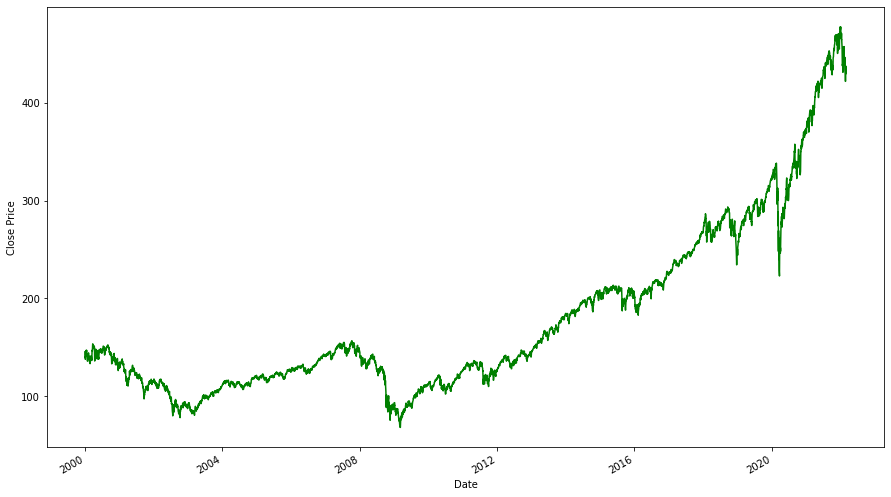

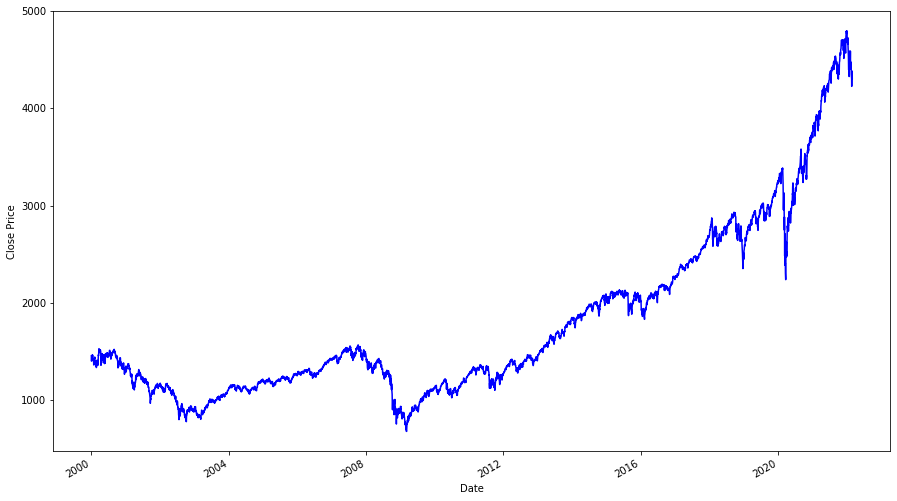

In [11]:
plt.figure(figsize = (15,9))
stocks['SPY'].Close.plot(c = 'g')
plt.ylabel('Close Price')
plt.show()

plt.figure(figsize = (15,9))
stocks['^GSPC'].Close.plot(c = 'b')
plt.ylabel('Close Price')
plt.show()

ticker_list.remove('^GSPC') # GSPC is an index and not tradeable

#### Correlation Plot
- `change` and `rsi` correlate with `return`

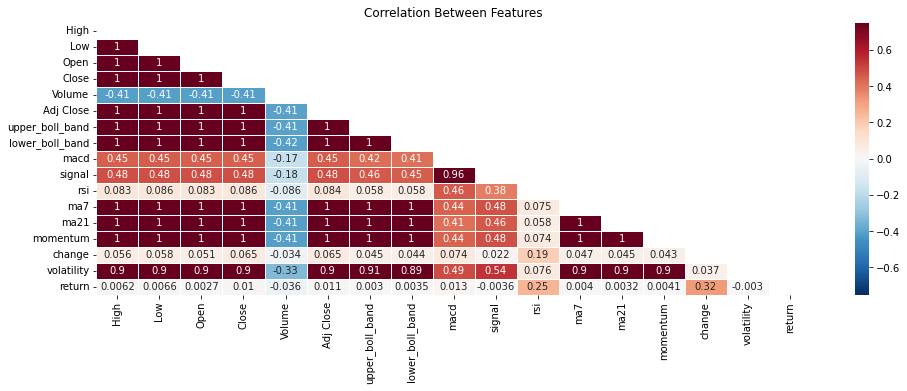

In [12]:
corr = apple_df.corr()

# Mask upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5, 
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
heatmap.set_title('Correlation Between Features');

In [13]:
corr[['return']].sort_values(by='return', ascending=False)

return
return           1.000000
change           0.316699
rsi              0.253477
macd             0.013279
Adj Close        0.010615
Close            0.010190
Low              0.006577
High             0.006203
momentum         0.004107
ma7              0.004040
lower_boll_band  0.003509
ma21             0.003216
upper_boll_band  0.002954
Open             0.002743
volatility      -0.003040
signal          -0.003610
Volume          -0.035970

## $\underline{\text{Plots}}$

### MACD - Moving Average Convergence Divergence  <a id = 3.1> </a> 
[Back to Top](#0)
- Momentum indicator showing relationship between two moving averages
- Logic is that momentum has more impact on short moving average and we subtract short_ma from long_ma
- Difference is sometimes positive or negative, hence the name MACD (moving average converge/diverge oscillator)
    - Oscillator is the difference between the two MAs
    - When it is positive, we long and vice versa
- If short_ma > long_ma, then long and hold as stock is on the rise and will keep going up for some time
- If short_ma < long_ma, then clear positions

In [14]:
def macd(stock):
    plt.figure(figsize=(16,5))
    plt.plot(stock.macd, label='short_ma', color = '#b278ff')
    plt.plot(stock.signal, label='long_ma', color='#ffa74a')
    plt.axhline(0, color='#557692')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('MACD', fontsize=15)
    plt.ylabel('Strength', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(16,5))
    (stock.macd - stock.signal).plot(kind='bar',color='r')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator', fontsize=15)
    plt.show()

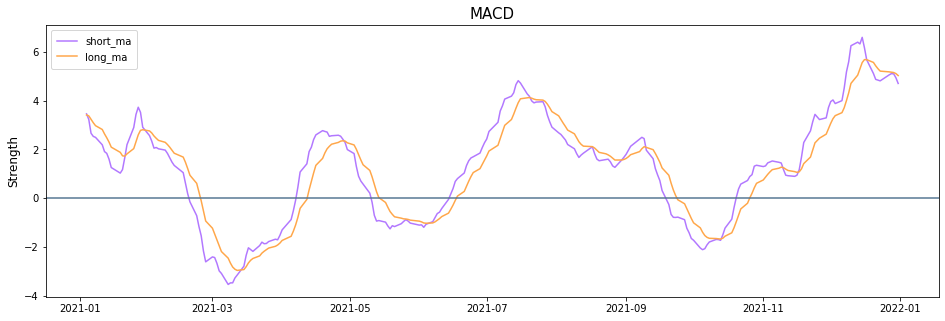

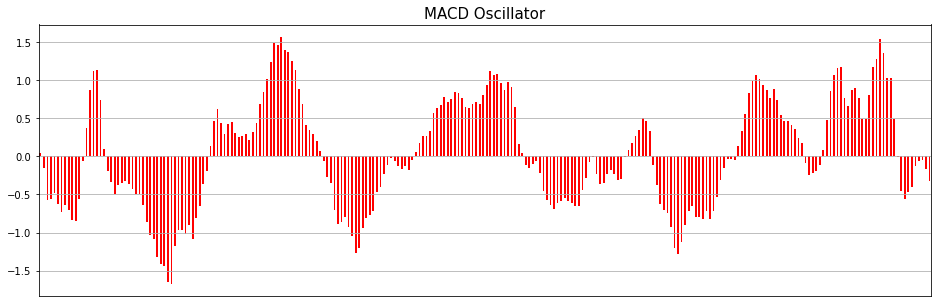

In [15]:
macd(apple_df.loc['2021':'2021'])

### Bollinger Bands  <a id = 3.2> </a> 
[Back to Top](#0)
- Price almost never leaves Bollinger Bands space
    - Price is fluctuating between three standard deviations
- Good indicator as buying/selling signal

In [16]:
def bollinger_bands_plot(stock, std=3):    
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.ma7, color='#ff6e9d', label='Moving Average (7 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label=f'Bollinger Band ({std} STD)')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Bollinger Bands', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()

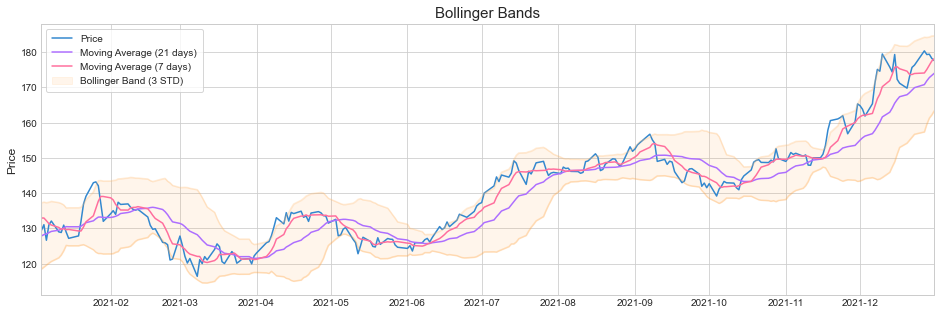

In [17]:
bollinger_bands_plot(apple_df.loc['2021':'2021'])

### RSI - Relative Strength Index <a id = 3.3> </a> 
[Back to Top](#0)
- A momentum indicator that can tell if stock is overbought or oversold
- Ranges from 0 to 100
- When index approaches 30, signal to buy
- When index approaches 70, signal to sell

In [18]:
def rsi(stock):
    plt.figure(figsize=(16,5)) 
    plt.plot(stock.index, stock.rsi, color='#ad6eff')
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.axhline(30, color='#f9989c')
    plt.axhline(70, color='#60e8ad')
    plt.title('RSI', fontsize=15)
    plt.ylabel('%', fontsize=12)
    plt.ylim([0, 100])
    plt.show()

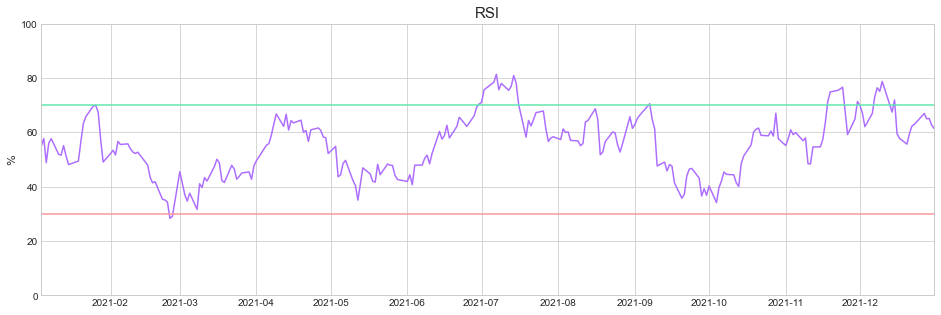

In [19]:
rsi(apple_df.loc['2021':'2021'])

### Normal Distribution <a id = 3.4> </a> 
[Back to Top](#0)
- ML algorithms require normal distribution of data to work well
- Target var `return` mostly normal

In [20]:
apple_df.head()

High       Low      Open     Close       Volume  Adj Close  \
Date                                                                         
2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.855796   
2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.783644   
2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.795111   
2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.726304   
2000-01-07  0.901786  0.852679  0.861607  0.888393  460734400.0   0.760708   

            upper_boll_band  lower_boll_band      macd    signal  rsi  ma7  \
Date                                                                         
2000-01-03              NaN              NaN  0.000000  0.000000  NaN  NaN   
2000-01-04              NaN              NaN -0.006722 -0.001344  NaN  NaN   
2000-01-05              NaN              NaN -0.010843 -0.003244  NaN  NaN   
2000-01-06              NaN              NaN -0.020359 -0.006667  NaN  NaN   
2000-01-07              NaN              NaN -0.024377 -0.010209  NaN  NaN   

            ma21  momentum    change  volatility  return  
Date                                                      
2000-01-03   NaN       NaN  0.000000         NaN  0.0673  
2000-01-04   NaN       NaN -0.084263    0.059583 -0.0531  
2000-01-05   NaN       NaN  0.013392    0.044683  0.0024  
2000-01-06   NaN -2.000558 -0.080357    0.061924 -0.1048  
2000-01-07   NaN -2.084821  0.040179    0.055008  0.0311

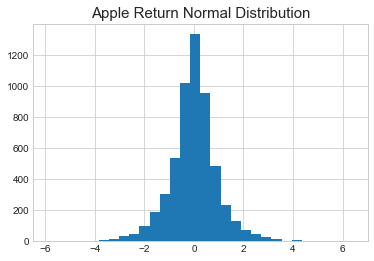

In [21]:
z = lambda x: (x - x.mean()) / x.std()

plt.hist(z(apple_df['return']), bins=30)
plt.title('Apple Return Normal Distribution', fontsize=15)
plt.show()

<Figure size 1152x360 with 0 Axes>

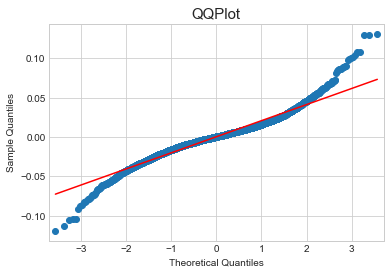

In [22]:
plt.figure(figsize=(16,5))
sm.qqplot(apple_df['return'], line='s', scale=1)
plt.title('QQPlot', fontsize=15);

## Model <a id = 4> </a> 
[Back to Top](#0)
- **Base Model:** Buy and Hold
- **Technical Indicator:** Bollinger Bands and MACD
- **NN Model:** LSTM
- **Deep Reinforcement Learning (DRL):** Evolution Strategy

### Base Model <a id = 4.0> </a> 

In [23]:
initial_cap = 10000

class BuyAndHold_Buy(bt.Strategy):
    def start(self):
        # set the starting cash
        self.val_start = self.broker.get_cash() 
    def nextstart(self):
        # Buy stocks with all the available cash
        size = int(self.val_start / self.data)
        self.buy(size=size)
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        globals()[f'base_ROI_{ticker_name}'] = round(self.roi*100,2)
        print("ROI: %.2f, Cash: %.2f" % (100.0 * self.roi, self.broker.get_value()))
        
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    data = bt.feeds.PandasData(dataname=yf.download(ticker_name, start=start, end=end, auto_adjust=True))
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold_Buy, "HODL")
    cerebro.broker.setcash(initial_cap)
    cerebro.run()


MSFT
[*********************100%***********************]  1 of 1 completed
ROI: 54.76, Cash: 15476.29

XOM
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

CVX
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

TSLA
[*********************100%***********************]  1 of 1 completed
ROI: 61.90, Cash: 16189.56

SPY
[*********************100%***********************]  1 of 1 completed
ROI: 30.90, Cash: 13090.21

AAPL
[*********************100%***********************]  1 of 1 completed
ROI: 41.46, Cash: 14145.77


### Technical Indicator - Bollinger Bands <a id = 4.1> </a> 
[Back to Top](#0)

In [24]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Trading History', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()


MSFT
Number of Trades: 24
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $710.08 | 7.1%


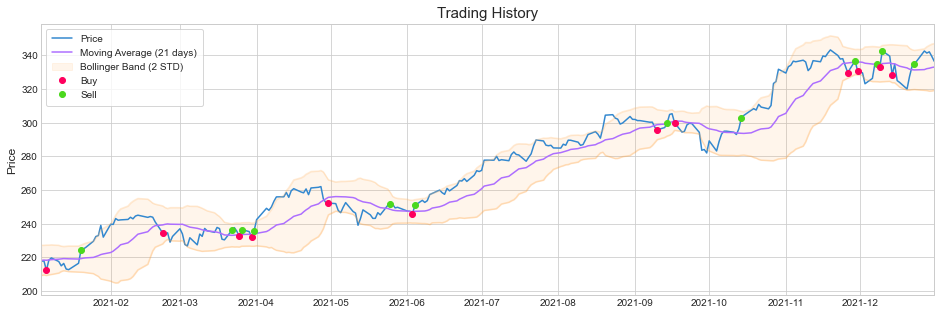


XOM
Number of Trades: 17
Time Frame: 261 days
Initial Capital: $10000
Percentage Gain: $-91.23 | -0.91%


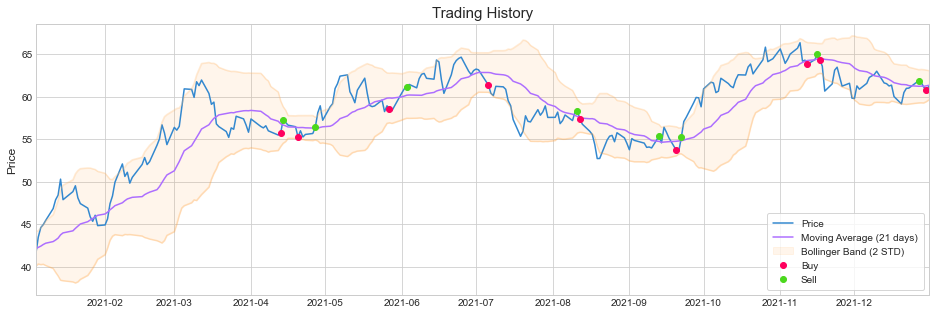


CVX
Number of Trades: 24
Time Frame: 327 days
Initial Capital: $10000
Percentage Gain: $2077.52 | 20.78%


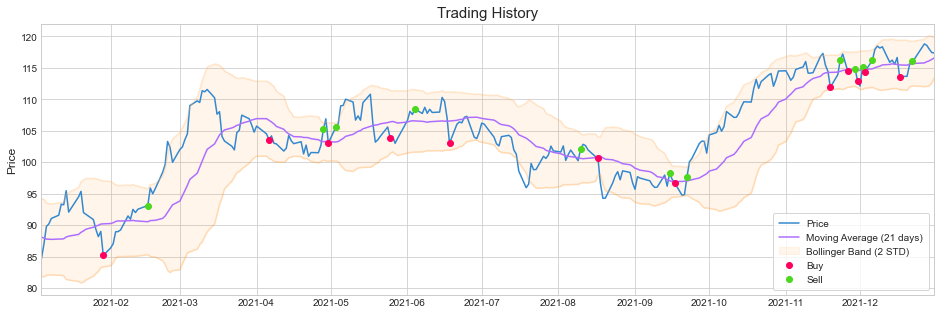


TSLA
Number of Trades: 7
Time Frame: 302 days
Initial Capital: $10000
Percentage Gain: $-2973.40 | -29.73%


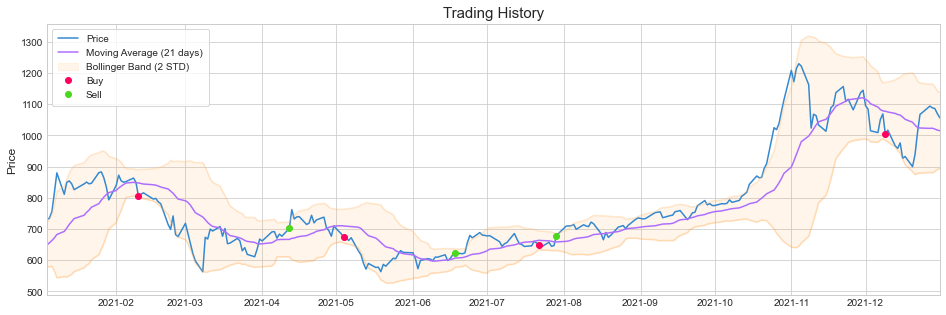


SPY
Number of Trades: 30
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $-1201.86 | -12.02%


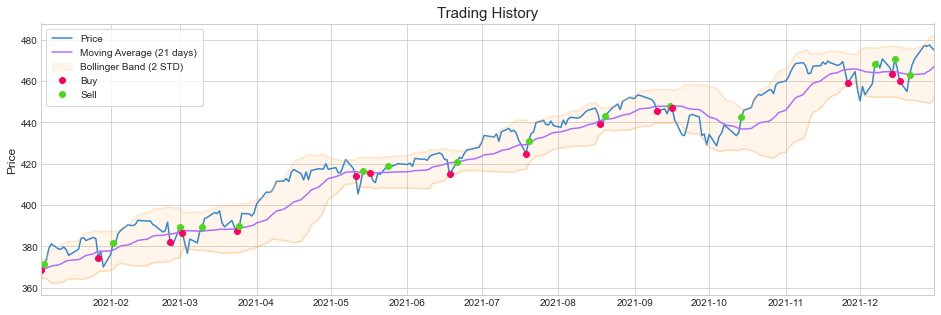


AAPL
Number of Trades: 14
Time Frame: 301 days
Initial Capital: $10000
Percentage Gain: $-850.61 | -8.51%


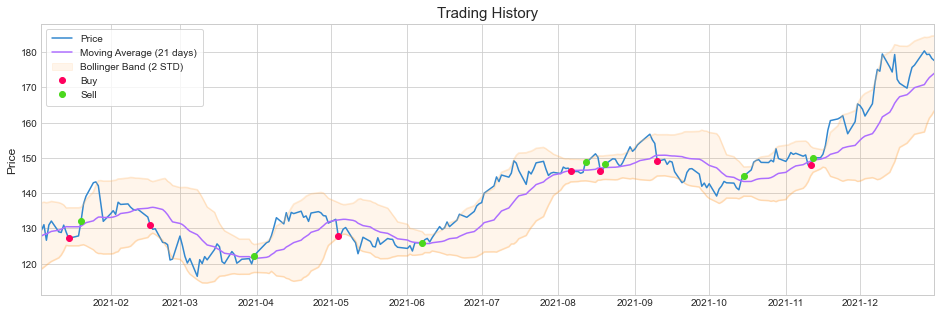

In [25]:
def bb_trading(stock, budget=10000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.ma21) and (abs(1 - today.Close / today.lower_boll_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.ma21) and (abs(1 - today.upper_boll_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Percentage Gain: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget

for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = bb_trading(stocks[ticker_name].loc['2021':'2021'], u=0.03, l=0.03);
    globals()[f'bb_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### Technical Indicator - MACD <a id = 4.2> </a> 
[Back to Top](#0)


MSFT
Number of Trades: 21
Time Frame: 340 days
Initial Capital: $10000
Profit: $1300.85 | 13.01%


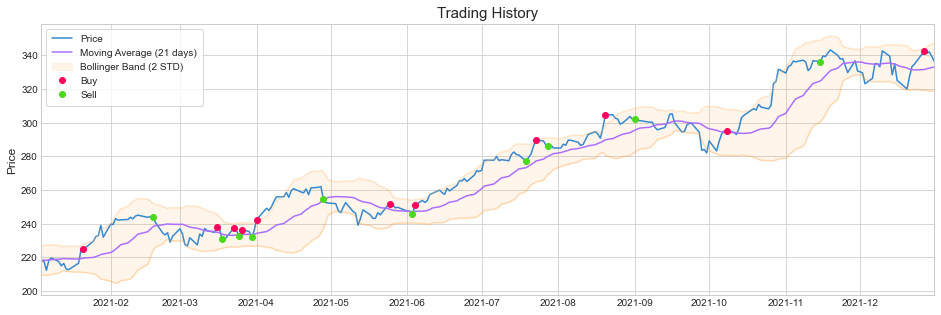


XOM
Number of Trades: 17
Time Frame: 354 days
Initial Capital: $10000
Profit: $2192.33 | 21.92%


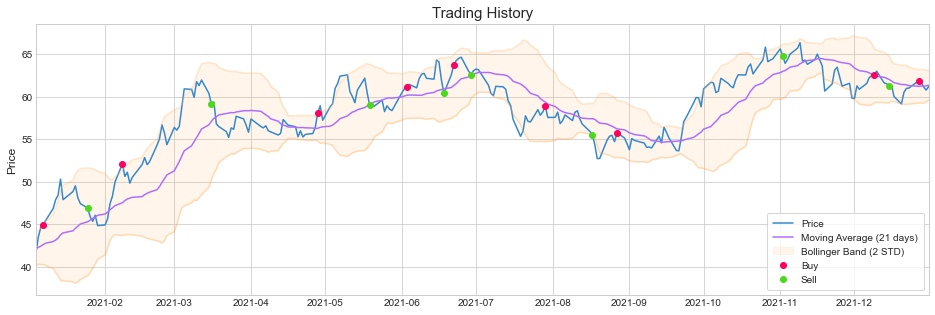


CVX
Number of Trades: 19
Time Frame: 355 days
Initial Capital: $10000
Profit: $1026.08 | 10.26%


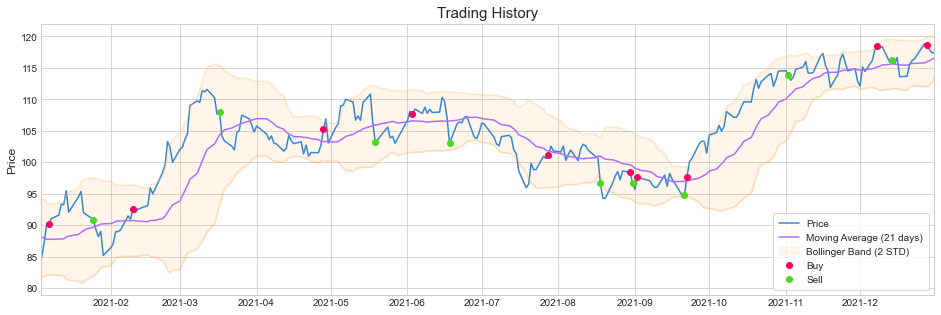


TSLA
Number of Trades: 19
Time Frame: 290 days
Initial Capital: $10000
Profit: $-3436.36 | -34.36%


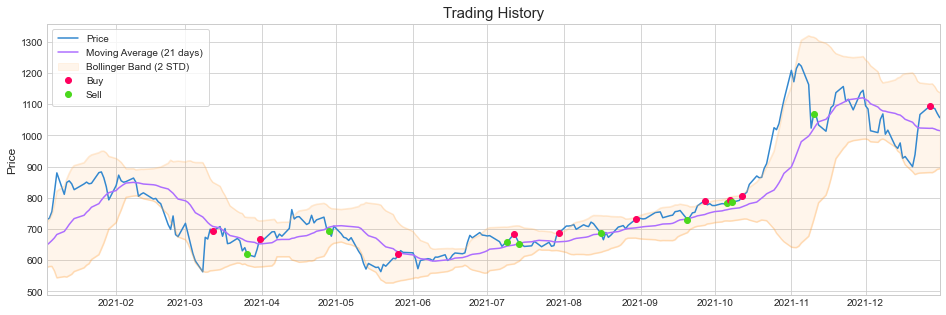


SPY
Number of Trades: 29
Time Frame: 350 days
Initial Capital: $10000
Profit: $-3882.20 | -38.82%


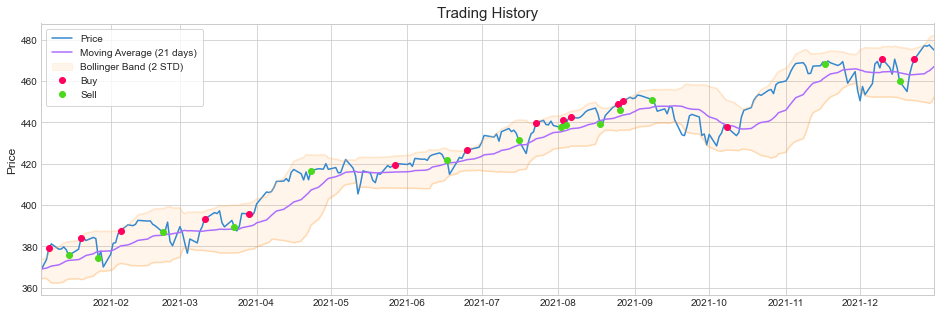


AAPL
Number of Trades: 12
Time Frame: 329 days
Initial Capital: $10000
Profit: $2835.50 | 28.35%


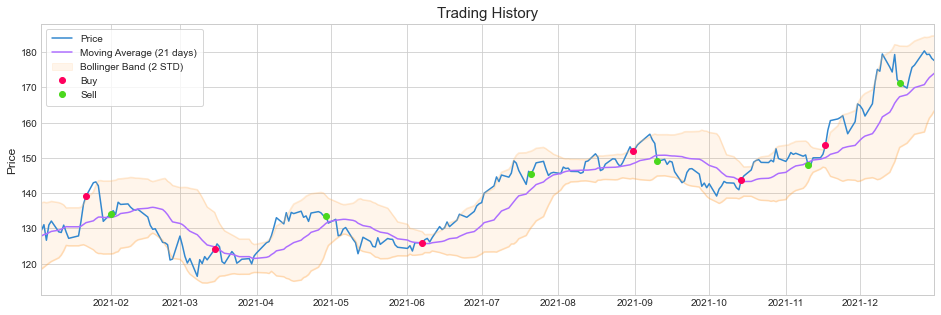

In [26]:
def macd_trading(stock, budget=10000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].macd, stock.loc[0].signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.macd, today.signal)

        if state != prev_state:

            # BUY
            if (today.macd > today.signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.macd < today.signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget


for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = macd_trading(stocks[ticker_name].loc['2021':'2021']);
    globals()[f'macd_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### LSTM <a id = 4.3> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 10s 106ms/step - loss: 0.0475
Epoch 2/5
21/21 [==============================] - 4s 175ms/step - loss: 0.0067
Epoch 3/5
21/21 [==============================] - 2s 86ms/step - loss: 0.0052
Epoch 4/5
21/21 [==============================] - 2s 76ms/step - loss: 0.0049
Epoch 5/5
21/21 [==============================] - 2s 76ms/step - loss: 0.0044


RMSE: 9.096230230046356


Initial Capital: $10000
Final Balance: $10790.74
Percentage Gain: 7.91%


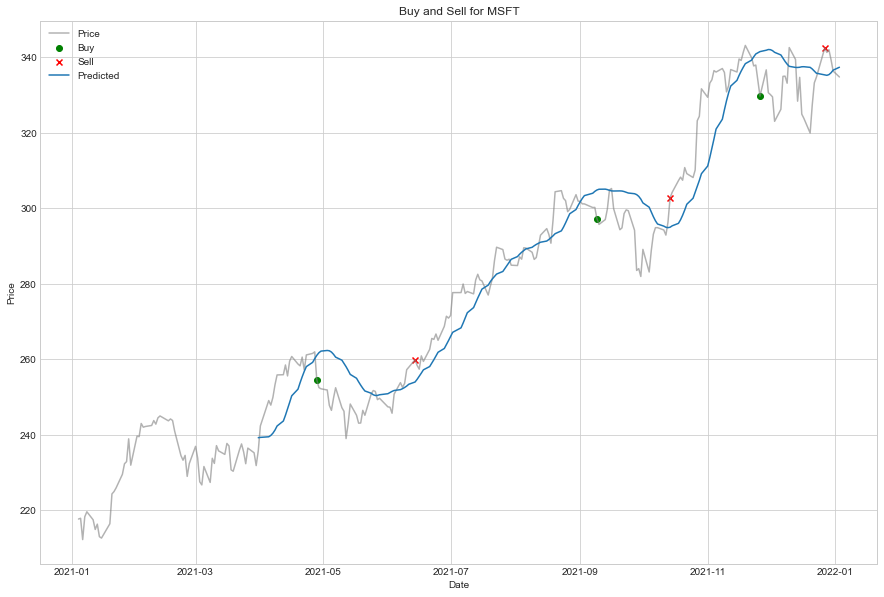


XOM
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 13s 105ms/step - loss: 0.0948
Epoch 2/5
21/21 [==============================] - 2s 84ms/step - loss: 0.0126
Epoch 3/5
21/21 [==============================] - 3s 130ms/step - loss: 0.0095
Epoch 4/5
21/21 [==============================] - 3s 122ms/step - loss: 0.0085
Epoch 5/5
21/21 [==============================] - 3s 139ms/step - loss: 0.0083


RMSE: 1.3028487431926141


Initial Capital: $10000
Final Balance: $11406.35
Percentage Gain: 14.06%


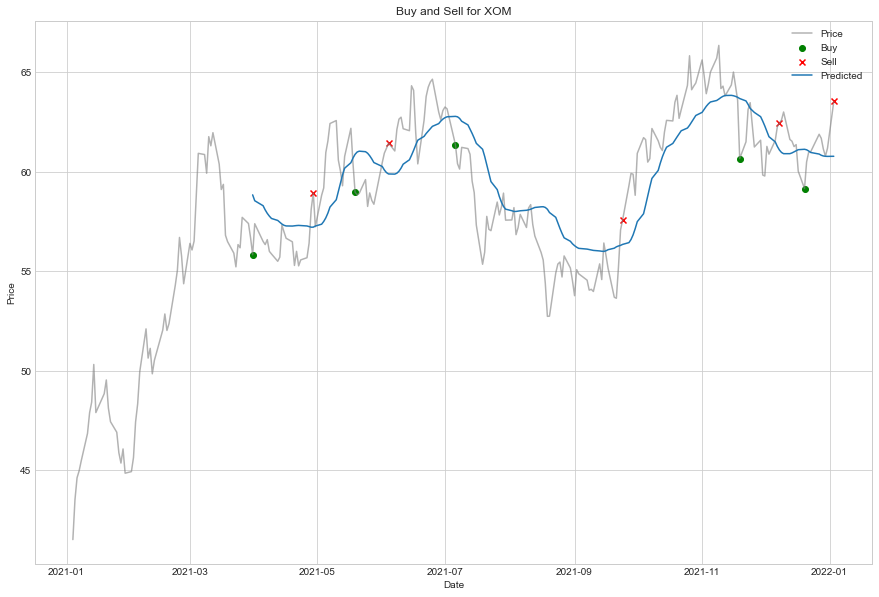


CVX
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 10s 95ms/step - loss: 0.0571
Epoch 2/5
21/21 [==============================] - 2s 75ms/step - loss: 0.0142
Epoch 3/5
21/21 [==============================] - 2s 96ms/step - loss: 0.0111
Epoch 4/5
21/21 [==============================] - 2s 102ms/step - loss: 0.0090
Epoch 5/5
21/21 [==============================] - 2s 88ms/step - loss: 0.0089


RMSE: 4.904194652493709


Initial Capital: $10000
Final Balance: $10495.64
Percentage Gain: 4.96%


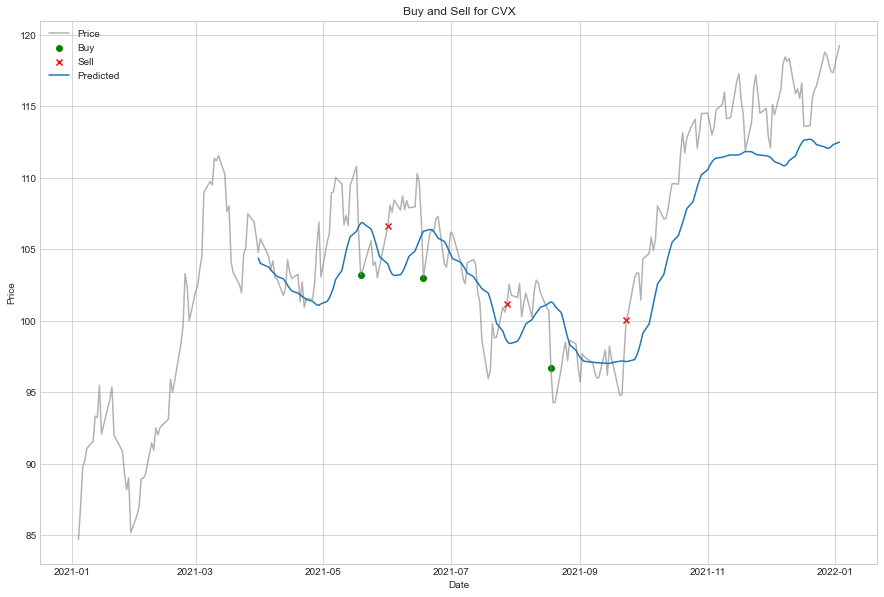


TSLA
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 8s 77ms/step - loss: 0.0325
Epoch 2/5
21/21 [==============================] - 2s 76ms/step - loss: 0.0138
Epoch 3/5
21/21 [==============================] - 2s 94ms/step - loss: 0.0135
Epoch 4/5
21/21 [==============================] - 2s 100ms/step - loss: 0.0108
Epoch 5/5
21/21 [==============================] - 2s 104ms/step - loss: 0.0086


RMSE: 82.15045103596066


Initial Capital: $10000
Final Balance: $12140.66
Percentage Gain: 21.41%


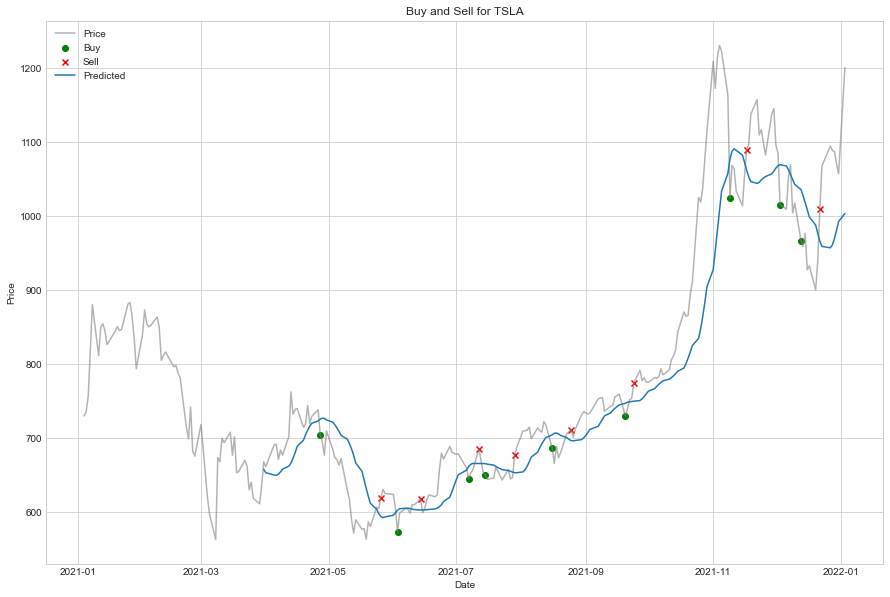


SPY
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 9s 84ms/step - loss: 0.0526
Epoch 2/5
21/21 [==============================] - 2s 93ms/step - loss: 0.0119
Epoch 3/5
21/21 [==============================] - 2s 91ms/step - loss: 0.0095
Epoch 4/5
21/21 [==============================] - 2s 84ms/step - loss: 0.0074
Epoch 5/5
21/21 [==============================] - 2s 96ms/step - loss: 0.0053


RMSE: 9.300955573084101


Initial Capital: $10000
Final Balance: $11360.08
Percentage Gain: 13.60%


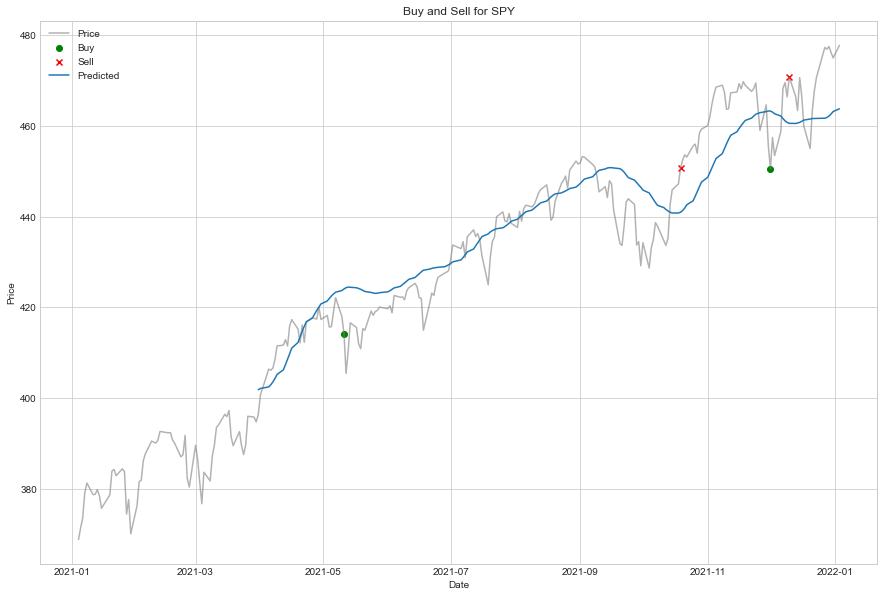


AAPL
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 14s 101ms/step - loss: 0.0188
Epoch 2/5
21/21 [==============================] - 4s 181ms/step - loss: 0.0074
Epoch 3/5
21/21 [==============================] - 3s 137ms/step - loss: 0.0056
Epoch 4/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0053
Epoch 5/5
21/21 [==============================] - 2s 96ms/step - loss: 0.0052


RMSE: 11.264768090075211


Initial Capital: $10000
Final Balance: $10405.20
Percentage Gain: 4.05%


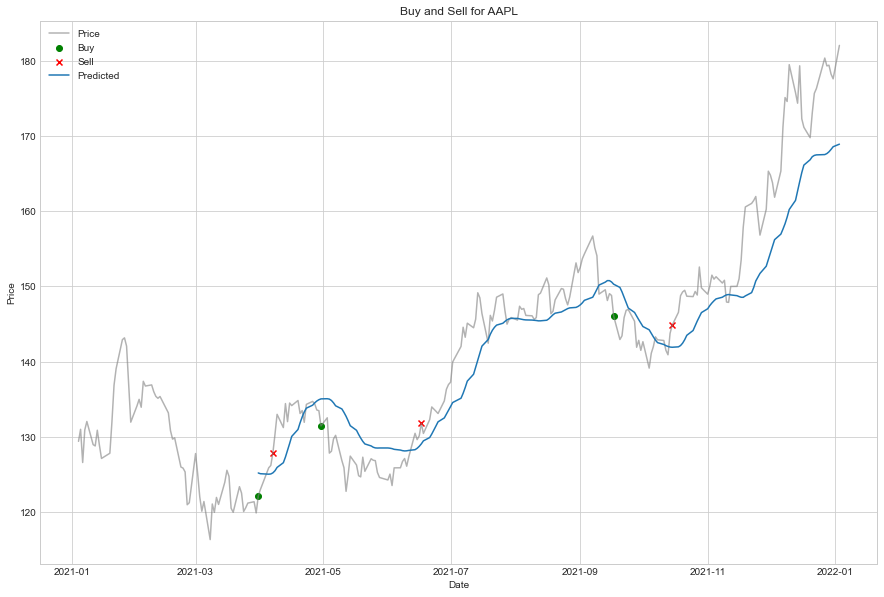

In [27]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_lstm.ipynb
    globals()[f'lstm_ROI_{ticker_name}'] = round(100*(agent.total_balance()-invest)/invest, 2)

### DRL - Evolution Strategy <a id = 4.4> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 5.682601
iter 20. reward: 8.687501
iter 30. reward: 5.779100
iter 40. reward: 15.968699
iter 50. reward: 10.204600
iter 60. reward: 10.775200
iter 70. reward: 14.497199
iter 80. reward: 14.892200
iter 90. reward: 15.635500
iter 100. reward: 24.591800
iter 110. reward: 10.876199
iter 120. reward: 16.833300
iter 130. reward: 22.619801
iter 140. reward: 21.329800
iter 150. reward: 25.537301
iter 160. reward: 22.490600
iter 170. reward: 21.193200
iter 180. reward: 23.770900
iter 190. reward: 25.257300
iter 200. reward: 21.737799
iter 210. reward: 22.882500
iter 220. reward: 20.669999
iter 230. reward: 23.421700
iter 240. reward: 21.362600
iter 250. reward: 22.612800
iter 260. reward: 23.965701
iter 270. reward: 25.254800
iter 280. reward: 27.139800
iter 290. reward: 28.385100
iter 300. reward: 29.292300
iter 310. reward: 27.994600
iter 320. reward: 27.477201
iter 330. reward: 31.957701
iter 340. rew

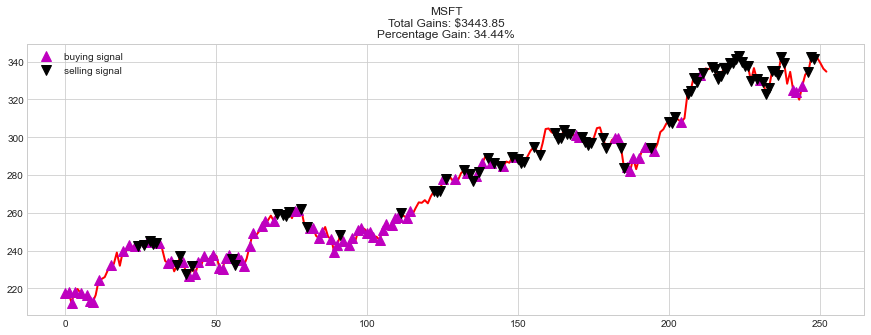


XOM
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 0.564700
iter 20. reward: 0.716200
iter 30. reward: 1.563800
iter 40. reward: 2.156700
iter 50. reward: 2.316800
iter 60. reward: 2.219100
iter 70. reward: 2.612100
iter 80. reward: 2.836900
iter 90. reward: 2.865200
iter 100. reward: 3.096200
iter 110. reward: 3.029800
iter 120. reward: 3.201200
iter 130. reward: 3.487700
iter 140. reward: 3.550400
iter 150. reward: 3.442900
iter 160. reward: 3.399300
iter 170. reward: 3.626300
iter 180. reward: 4.025700
iter 190. reward: 3.818200
iter 200. reward: 2.348700
iter 210. reward: 3.498700
iter 220. reward: 3.932200
iter 230. reward: 4.283800
iter 240. reward: 4.296800
iter 250. reward: 3.591200
iter 260. reward: 4.223100
iter 270. reward: 2.894100
iter 280. reward: 3.814000
iter 290. reward: 3.961300
iter 300. reward: 4.184700
iter 310. reward: 3.903900
iter 320. reward: 4.139100
iter 330. reward: 4.474100
iter 340. reward: 4.174500
iter 350. reward:

day 129, sell 1 unit at price 61.230000, investment 3.885309 %, total balance 9914.000004,
day 130, sell 1 unit at price 61.169998, investment -1.608493 %, total balance 9975.170002,
day 132, sell 1 unit at price 59.529999, investment -7.461531 %, total balance 10034.700001,
day 134, sell 1 unit at price 57.320000, investment -5.099341 %, total balance 10092.020000,
day 135, sell 1 unit at price 55.349998, investment -14.398399 %, total balance 10147.369999,
day 139, sell 1 unit at price 57.040001, investment -8.910888 %, total balance 10204.410000,
day 141: buy 1 unit at price 57.830002, total balance 10146.579998
day 142: buy 1 unit at price 58.220001, total balance 10088.359997
day 144: buy 1 unit at price 57.570000, total balance 10030.789997
day 145, sell 1 unit at price 57.580002, investment -0.432302 %, total balance 10088.369999,
day 146, sell 1 unit at price 58.200001, investment -0.034353 %, total balance 10146.570000,
day 147: buy 1 unit at price 56.840000, total balance 100

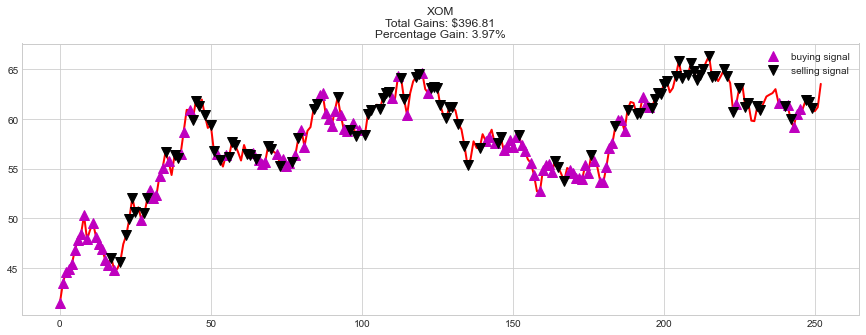


CVX
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 0.607000
iter 20. reward: 1.261300
iter 30. reward: 2.124600
iter 40. reward: 2.644900
iter 50. reward: 3.096400
iter 60. reward: 3.012500
iter 70. reward: 3.466300
iter 80. reward: 3.654300
iter 90. reward: 4.211700
iter 100. reward: 4.641800
iter 110. reward: 4.599900
iter 120. reward: 4.773400
iter 130. reward: 4.778700
iter 140. reward: 5.079400
iter 150. reward: 5.452000
iter 160. reward: 4.951600
iter 170. reward: 5.589100
iter 180. reward: 5.782800
iter 190. reward: 5.830000
iter 200. reward: 5.761600
iter 210. reward: 5.725600
iter 220. reward: 5.345700
iter 230. reward: 5.908000
iter 240. reward: 5.891600
iter 250. reward: 5.686100
iter 260. reward: 6.101500
iter 270. reward: 5.830500
iter 280. reward: 6.026800
iter 290. reward: 5.098600
iter 300. reward: 5.772100
iter 310. reward: 5.795400
iter 320. reward: 5.876200
iter 330. reward: 6.252000
iter 340. reward: 6.353200
iter 350. reward:

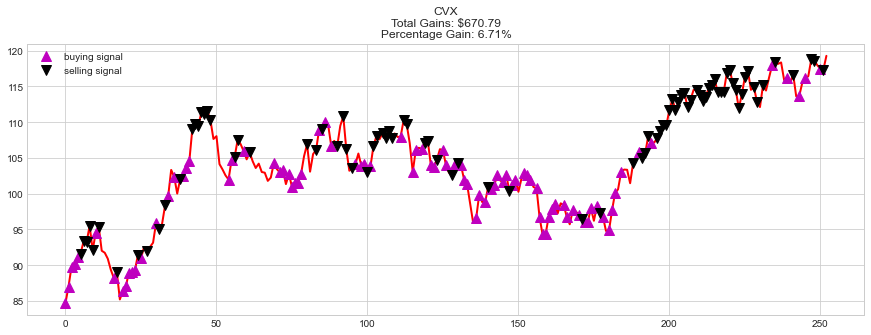


TSLA
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 14.916897
iter 20. reward: 49.088599
iter 30. reward: 51.259901
iter 40. reward: 62.416597
iter 50. reward: 70.552100
iter 60. reward: 73.285399
iter 70. reward: 78.750897
iter 80. reward: 79.742997
iter 90. reward: 82.754899
iter 100. reward: 93.187500
iter 110. reward: 92.783701
iter 120. reward: 91.967198
iter 130. reward: 94.959000
iter 140. reward: 92.903699
iter 150. reward: 94.506498
iter 160. reward: 96.936899
iter 170. reward: 96.338400
iter 180. reward: 98.587398
iter 190. reward: 90.290099
iter 200. reward: 97.152098
iter 210. reward: 99.477798
iter 220. reward: 91.483098
iter 230. reward: 97.029998
iter 240. reward: 95.600098
iter 250. reward: 92.741398
iter 260. reward: 97.795798
iter 270. reward: 85.606797
iter 280. reward: 100.391497
iter 290. reward: 98.603696
iter 300. reward: 98.991996
iter 310. reward: 96.142897
iter 320. reward: 99.275197
iter 330. reward: 98.946596
iter 340.

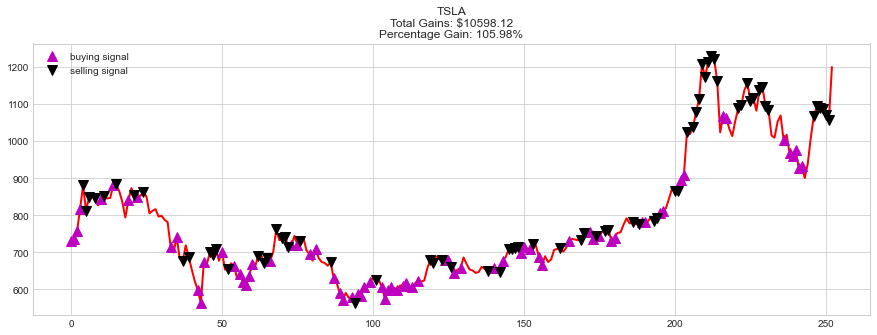


SPY
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 2.166100
iter 20. reward: 3.150700
iter 30. reward: 4.275000
iter 40. reward: 4.889200
iter 50. reward: 5.566600
iter 60. reward: 6.235799
iter 70. reward: 6.671199
iter 80. reward: 8.630699
iter 90. reward: 6.776499
iter 100. reward: 7.916698
iter 110. reward: 10.813398
iter 120. reward: 11.000399
iter 130. reward: 10.437498
iter 140. reward: 9.789799
iter 150. reward: 9.641599
iter 160. reward: 10.937399
iter 170. reward: 10.521499
iter 180. reward: 8.753799
iter 190. reward: 13.349299
iter 200. reward: 12.708699
iter 210. reward: 12.607499
iter 220. reward: 12.328600
iter 230. reward: 12.859200
iter 240. reward: 13.670399
iter 250. reward: 13.658299
iter 260. reward: 13.280899
iter 270. reward: 13.331100
iter 280. reward: 11.389099
iter 290. reward: 14.614299
iter 300. reward: 14.184099
iter 310. reward: 14.425098
iter 320. reward: 14.373599
iter 330. reward: 13.244499
iter 340. reward: 14.286

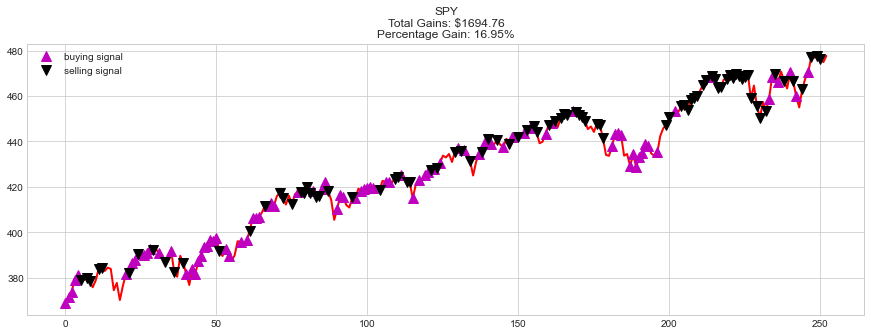


AAPL
[*********************100%***********************]  1 of 1 completed
iter 10. reward: -0.422301
iter 20. reward: 2.764299
iter 30. reward: 2.121900
iter 40. reward: 6.560400
iter 50. reward: 6.385500
iter 60. reward: 7.064300
iter 70. reward: 5.211800
iter 80. reward: 8.046401
iter 90. reward: 2.728701
iter 100. reward: 11.563501
iter 110. reward: 10.893000
iter 120. reward: 8.889100
iter 130. reward: 11.299601
iter 140. reward: 11.119501
iter 150. reward: 10.474700
iter 160. reward: 13.337400
iter 170. reward: 14.005100
iter 180. reward: 12.150700
iter 190. reward: 13.329300
iter 200. reward: 12.526800
iter 210. reward: 12.290201
iter 220. reward: 13.742900
iter 230. reward: 11.861100
iter 240. reward: 11.217000
iter 250. reward: 11.861800
iter 260. reward: 9.746201
iter 270. reward: 12.149900
iter 280. reward: 8.146200
iter 290. reward: 14.574900
iter 300. reward: 13.929300
iter 310. reward: 13.089100
iter 320. reward: 12.550500
iter 330. reward: 12.080900
iter 340. reward: 14.

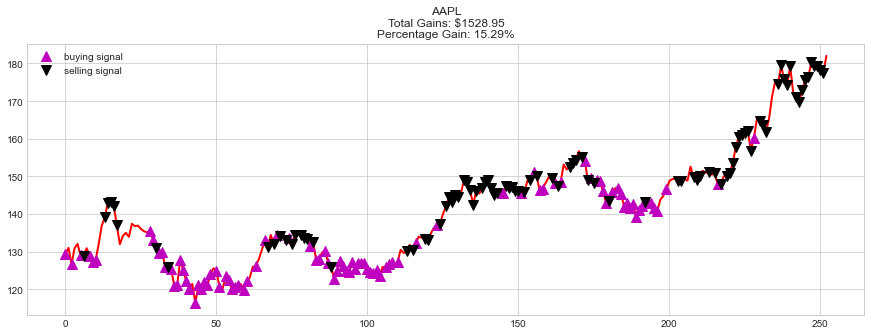

In [28]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_es.ipynb
    globals()[f'es_ROI_{ticker_name}'] = round(invest, 2)

## Results <a id = 5> </a> 
[Back to Top](#0)

In [29]:
algo_list = ['base_ROI_', 'bb_ROI_', 'macd_ROI_', 'lstm_ROI_', 'es_ROI_']
gen_list = []

for a in algo_list:
    for t in ticker_list:
        gen_list.append(a+t)

models_list = ['Base Model', 'Bollinger Bands', 'MACD', 'LSTM', 'Evolution Strategy']

def average(y):
    return str(round(sum([float(x.split(' ')[0]) for x in y])/len(y),1))+' %'

base = [f'{eval(x):.1f} %' for x in gen_list if algo_list[0] in x]
base_ave = average(base)

bb = [f'{eval(x):.1f} %' for x in gen_list if algo_list[1] in x]
bb_ave = average(bb)

macd = [f'{eval(x):.1f} %' for x in gen_list if algo_list[2] in x]
macd_ave = average(macd)

lstm = [f'{eval(x):.1f} %' for x in gen_list if algo_list[3] in x]
lstm_ave = average(lstm)

es = [f'{eval(x):.1f} %' for x in gen_list if algo_list[4] in x]
es_ave = average(es)

In [30]:
fig = go.Figure(data=[go.Table(
    columnwidth = [300, 400],
    header=dict(values=['']+models_list,
                line_color='darkslategray',
                fill_color='royalblue',
                align='center',
                font=dict(color='white', size=14)
               ),
    cells=dict(values=[
                 ticker_list+['<b>Average</b>'],
                 base+['<b>'+base_ave+'</b>'], 
                 bb+['<b>'+bb_ave+'</b>'],
                 macd+['<b>'+macd_ave+'</b>'],
                 lstm+['<b>'+lstm_ave+'</b>'],
                 es+['<b>'+es_ave+'</b>']
                 ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center',
               font=dict(color='black', size=12)
              )
)])
fig.show()

## Conclusion <a id = 6> </a> 
[Back to Top](#0)

- **Base model (buy and hold strategy)** on average performed the best with **average ROI of 31.5%**
- Technical indicators Bollinger Bands and MACD did very poorly
- Machine learning models fared better compared to technical indicators
- The stock market is a very volatile and complex system
- Historical data is not enough to explain its behavior


## Future Work <a id = 7> </a> 
[Back to Top](#0)

To improve our predictions, the below could be performed for future considerations:
- Continue refining the hyperparameters of current models
- Utilize other models such as ADX (Average Directional Movement Index) and other DRL models
- Fundamental analysis
- Sentiment analysis (twitter, news, social media etc.)
- Local/global economy analysis

## References <a id = 8> </a> 
[Back to Top](#0)

- Turin, A. (2020, March 8). Machine Learning for day trading. Medium. Retrieved March 2, 2022, from towardsdatascience.com/machine-learning-for-day-trading-27c08274df54.

- Jansen, Stefan. “Machine Learning for Algorithmic Trading.” GitHub, PacktPublishing, github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition.

- T.M. “Quant-Trading.” GitHub, 1 Mar. 2022, github.com/je-suis-tm/quant-trading. Accessed 2 Mar. 2022.

- Dector, Aldo. “Moving-Average-Trading-Strategy-With-Python.” GitHub, 25 Nov. 2021, github.com/aldodec/Moving-Average-Trading-Strategy-with-Python. Accessed 2 Mar. 2022.

- Zhang, Leon. “Algorithmic Stock Trading.” GitHub, 30 Jan. 2022, github.com/leonz12345/Algorithmic_Stock_Trading. Accessed 2 Mar. 2022.

- ZOLKEPLI, HUSEIN. “Huseinzol05/Stock-Prediction-Models.” GitHub, 1 Mar. 2022, github.com/huseinzol05/Stock-Prediction-Models. Accessed 2 Mar. 2022.

- Orac, Roman. “Buy and Hold Trading Strategy.” Medium, 13 Dec. 2020, towardsdatascience.com/buy-and-hold-trading-strategy-66b4c3ac9b68. Accessed 2 Mar. 2022.